In [1]:
import torch
import sys
import os

# 1. Add parent directory to path to import the model class
sys.path.append(os.path.abspath('..'))
from models.PhysicModel import OmniRobotDynamic

# 2. Define the path to the saved weights
model_path = '../models/trained/omni_robot_dynamic_weights.pth'

# 3. Instantiate the model structure (ensure dt matches training)
model = OmniRobotDynamic(dt=0.016)

# 4. Load the weights
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval() # Set to evaluation mode
    print("Model loaded successfully.")
    print(f"Loaded Motor Gains: {model.motor_gains.data}")
    print(f"Loaded Friction Coeffs: {model.friction_coeffs.data}")
else:
    print(f"Error: Model file not found at {model_path}")

Model loaded successfully.
Loaded Motor Gains: tensor([1.6267, 1.8213, 2.1380, 2.1439])
Loaded Friction Coeffs: tensor([2.2606, 1.8770, 1.5730, 2.0549])


C:\Users\Gerso\AppData\Local\Temp\ipykernel_12088\1816219222.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [3]:
import pandas as pd

df = pd.read_csv("../dataset/processed_data/data0.csv")
df.head()

,Unnamed: 0,vx,vy,omega,vx_cmd,vy_cmd,omega_cmd,filtered_x,filtered_y,x,y
0,0,0.000000,0.000000,0.000000,0.0,0.0,-3.41724,-0.141153,-0.082645,-0.141153,-0.082645
1,1,-0.047538,0.278635,-0.137952,0.0,0.0,-3.65059,-0.142632,-0.073978,-0.142975,-0.071965
2,2,-0.068834,0.396873,-0.308679,0.0,0.0,-3.86224,-0.144346,-0.064222,-0.144808,-0.061659
3,3,-0.081398,0.465380,-0.466342,0.0,0.0,-4.06502,-0.146147,-0.054059,-0.146638,-0.051382
4,4,-0.090642,0.508263,-0.648098,0.0,0.0,-4.23785,-0.148028,-0.043929,-0.148531,-0.041596


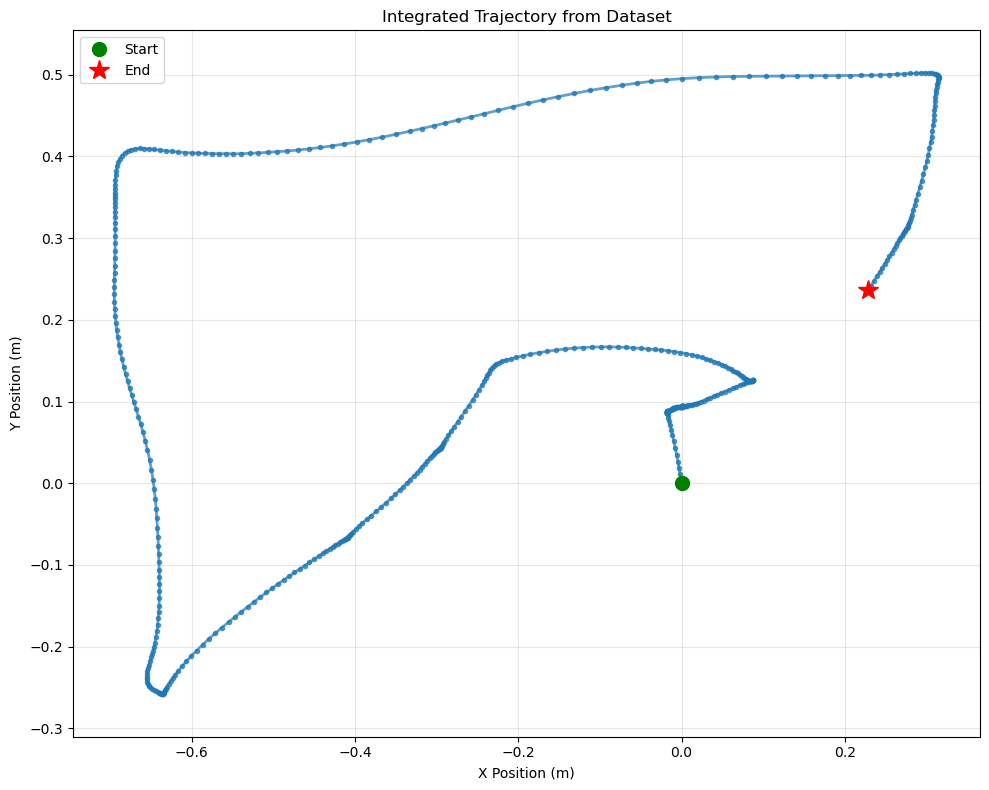

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory_from_velocities(velocities, dt=0.016, title="Robot Trajectory"):
    """
    Plots the trajectory of a robot by integrating velocities using Euler method.
    
    Args:
        velocities: List of tuples (vx, vy, omega) representing velocities at each time step
        dt: Time step for integration (seconds), default 0.01
        title: Title for the plot
    """
    # Initialize position and heading
    x, y, theta = 0.0, 0.0, 0.0
    positions_x = [x]
    positions_y = [y]
    
    # Integrate velocities to get positions
    for vx, vy, omega in velocities:
        # Update heading
        theta += omega * dt
        
        # Update position in global frame
        x += vx * dt
        y += vy * dt
        
        positions_x.append(x)
        positions_y.append(y)
    
    # Plot the trajectory
    plt.figure(figsize=(10, 8))
    plt.plot(positions_x, positions_y, linewidth=2, marker='o', markersize=3, alpha=0.7)
    plt.plot(positions_x[0], positions_y[0], 'go', markersize=10, label='Start')
    plt.plot(positions_x[-1], positions_y[-1], 'r*', markersize=15, label='End')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage with your dataframe
velocities = list(zip(df['vx'], df['vy'], df['omega']))
velocities = velocities[:500]
plot_trajectory_from_velocities(velocities, title="Integrated Trajectory from Dataset")

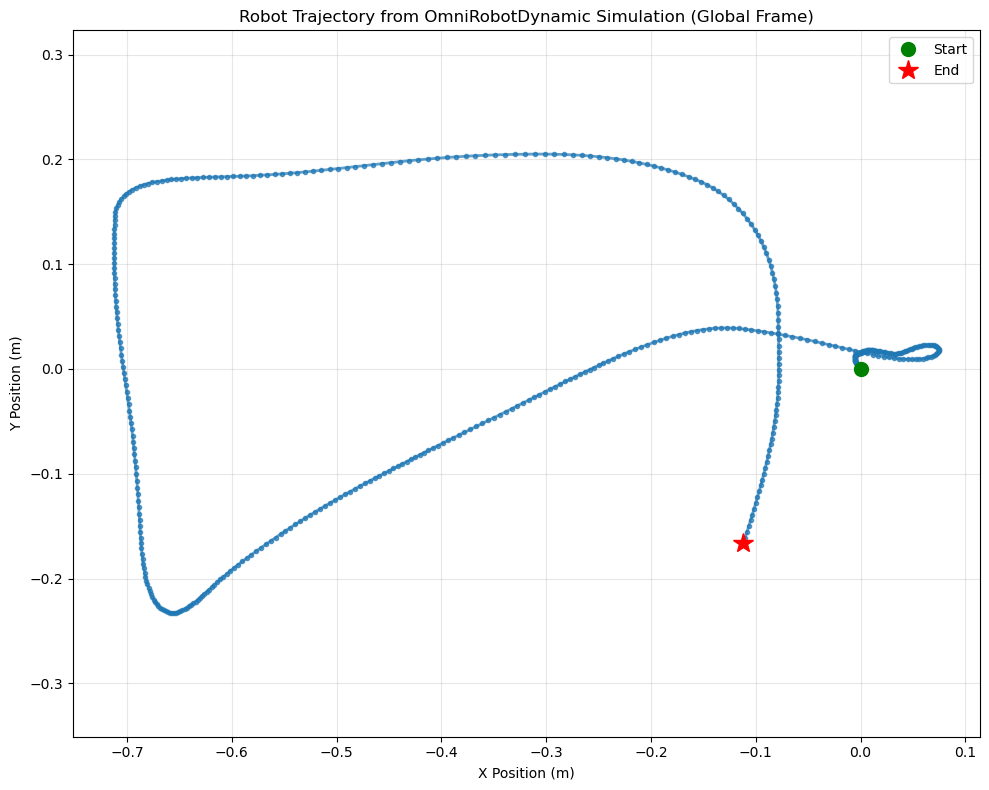

In [5]:
import pandas as pd



# Extract command velocities from dataframe
commands_list = list(zip(df['vx_cmd'], df['vy_cmd'], df['omega_cmd']))
commands_list = commands_list[:500]

# Initialize robot
robot = model
robot.eval()  # Set to evaluation mode

# Initial state
state = torch.zeros((1, 3))  # [vx, vy, omega]
theta = torch.zeros((1, 1))  # Heading angle
simulated_velocities = []

with torch.no_grad():  # No gradient computation during inference
    for cmd in commands_list:
        # Convert command to tensor
        cmd_tensor = torch.tensor([[cmd[0], cmd[1], cmd[2]]], dtype=torch.float32)
        
        # Forward pass
        state, theta = robot(state, cmd_tensor, theta)
        
        # Convert to numpy and append
        vx, vy, omega = state[0, 0].item(), state[0, 1].item(), state[0, 2].item()
        theta_val = theta[0, 0].item()
        
        # Convert local velocities to global frame
        cos_t = np.cos(theta_val)
        sin_t = np.sin(theta_val)
        
        vx_global = cos_t * vx - sin_t * vy
        vy_global = sin_t * vx + cos_t * vy
        
        simulated_velocities.append((vx_global, vy_global, omega))

# Plot the trajectory from simulated velocities in global frame
plot_trajectory_from_velocities(simulated_velocities, dt=0.016, 
                                 title="Robot Trajectory from OmniRobotDynamic Simulation (Global Frame)")

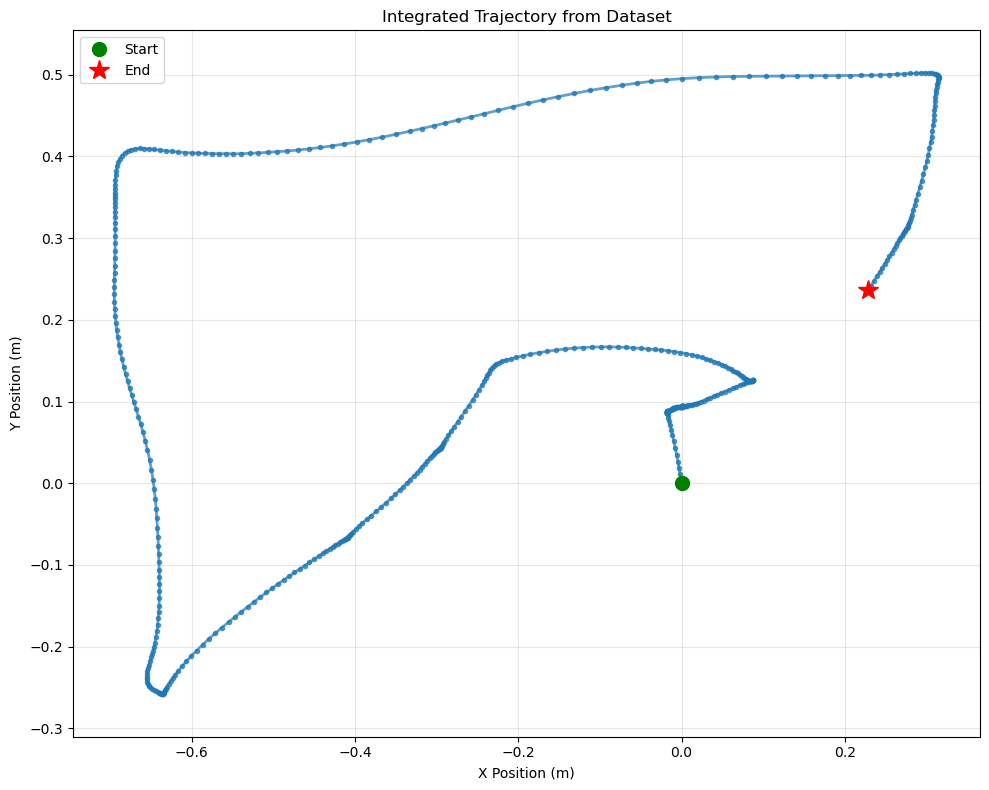

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory_from_velocities(velocities, dt=0.016, title="Robot Trajectory"):
    """
    Plots the trajectory of a robot by integrating velocities using Euler method.
    
    Args:
        velocities: List of tuples (vx, vy, omega) representing velocities at each time step
        dt: Time step for integration (seconds), default 0.01
        title: Title for the plot
    """
    # Initialize position and heading
    x, y, theta = 0.0, 0.0, 0.0
    positions_x = [x]
    positions_y = [y]
    
    # Integrate velocities to get positions
    for vx, vy, omega in velocities:
        # Update heading
        theta += omega * dt
        
        # Update position in global frame
        x += vx * dt
        y += vy * dt
        
        positions_x.append(x)
        positions_y.append(y)
    
    # Plot the trajectory
    plt.figure(figsize=(10, 8))
    plt.plot(positions_x, positions_y, linewidth=2, marker='o', markersize=3, alpha=0.7)
    plt.plot(positions_x[0], positions_y[0], 'go', markersize=10, label='Start')
    plt.plot(positions_x[-1], positions_y[-1], 'r*', markersize=15, label='End')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage with your dataframe
velocities = list(zip(df['vx'], df['vy'], df['omega']))
velocities = velocities[:500]
plot_trajectory_from_velocities(velocities, title="Integrated Trajectory from Dataset")

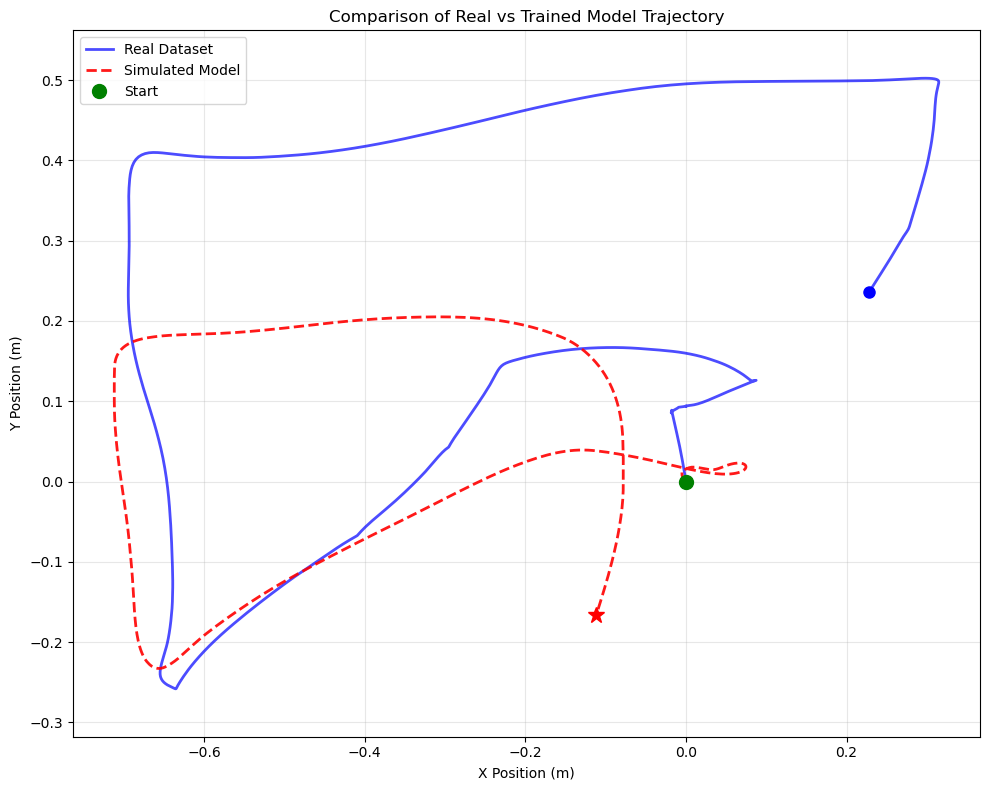

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_trajectories(real_velocities, simulated_velocities, dt=0.016, title="Real vs Simulated Trajectory"):
    """
    Plots the real and simulated trajectories on the same plot for comparison.
    
    Args:
        real_velocities: List of tuples (vx, vy, omega) from the dataset
        simulated_velocities: List of tuples (vx, vy, omega) from the robot simulation
        dt: Time step for integration (seconds), default 0.016
        title: Title for the plot
    """
    # Helper to integrate trajectory
    def integrate_trajectory(velocities):
        x, y, theta = 0.0, 0.0, 0.0
        xs = [x]
        ys = [y]
        for vx, vy, omega in velocities:
            theta += omega * dt
            x += vx * dt
            y += vy * dt
            xs.append(x)
            ys.append(y)
        return xs, ys

    # Comparisons must be same length
    min_len = min(len(real_velocities), len(simulated_velocities))
    real_velocities = real_velocities[:min_len]
    simulated_velocities = simulated_velocities[:min_len]
    
    # Integrate both
    real_x, real_y = integrate_trajectory(real_velocities)
    sim_x, sim_y = integrate_trajectory(simulated_velocities)
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # Plot Real
    plt.plot(real_x, real_y, linewidth=2, linestyle='-', color='blue', label='Real Dataset', alpha=0.7)
    plt.plot(real_x[-1], real_y[-1], 'bo', markersize=8) # End point
    
    # Plot Simulated
    plt.plot(sim_x, sim_y, linewidth=2, linestyle='--', color='red', label='Simulated Model', alpha=0.9)
    plt.plot(sim_x[-1], sim_y[-1], 'r*', markersize=12) # End point
    
    # Start point (common)
    plt.plot(real_x[0], real_y[0], 'go', markersize=10, label='Start')
    
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Usage Example
real_vels = list(zip(df['vx'], df['vy'], df['omega']))[:1000] 
# simulated_velocities is already available from previous cell

plot_comparison_trajectories(real_vels, simulated_velocities, 
                             title="Comparison of Real vs Trained Model Trajectory")

# Residual model

In [11]:
import torch.nn as nn

# --- 1. Define Residual Model Class (Must match training definition) ---
class PhysicsResidualModel(nn.Module):
    def __init__(self, physics_model, hidden_dim=64):
        """
        A hybrid model:
        v_{t+1} = Physics(v_t, cmd_t) + Network(v_t, cmd_t)
        """
        super().__init__()
        self.physics_model = physics_model
        self.dt = physics_model.dt
        
        # Residual Network
        self.residual_net = nn.Sequential(
            nn.Linear(6, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3) 
        )

    def forward(self, current_vel, commands, theta):
        physics_next_vel, _ = self.physics_model(current_vel, commands, theta)
        
        inputs = torch.cat([current_vel, commands], dim=1)
        residual_correction = self.residual_net(inputs)
        
        final_next_vel = physics_next_vel + residual_correction
        
        omega_new = final_next_vel[:, 2]
        theta_new = theta.squeeze() + omega_new * self.dt
        theta_new = torch.atan2(torch.sin(theta_new), torch.cos(theta_new)).unsqueeze(-1)
        
        return final_next_vel, theta_new

# --- 2. Load Hybrid Model ---
hybrid_path = '../models/trained/hybrid_physics_residual_weights.pth'

# Initialize Base Physics Model first
base_model = OmniRobotDynamic(dt=0.016)

# Initialize Hybrid Model wrapper
hybrid_model = PhysicsResidualModel(base_model, hidden_dim=64)

if os.path.exists(hybrid_path):
    hybrid_model.load_state_dict(torch.load(hybrid_path))
    hybrid_model.eval()
    print("Hybrid Physics+Residual Model loaded successfully.")
else:
    print(f"Error: Hybrid model file not found at {hybrid_path}")

Hybrid Physics+Residual Model loaded successfully.


C:\Users\Gerso\AppData\Local\Temp\ipykernel_12088\3376276606.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hybrid_model.load_state_dict(torch.load(hybrid_path))


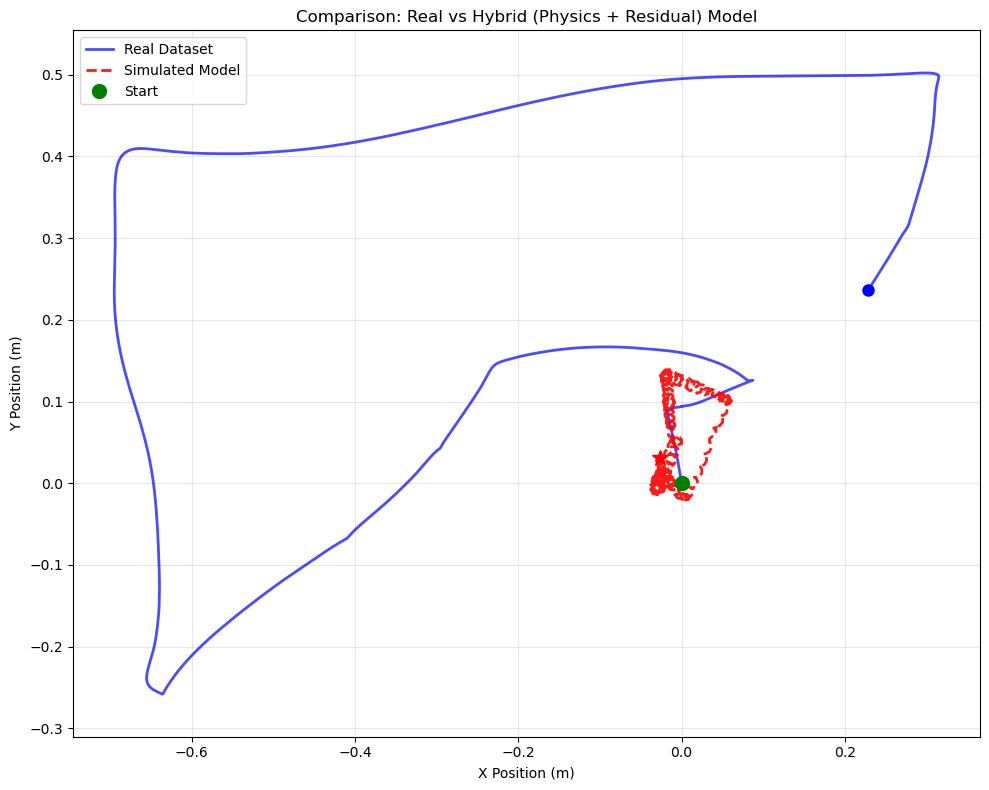

In [12]:
# --- Select Data ---
# Extract real velocities and commands (first 500 steps)
real_vels = list(zip(df['vx'], df['vy'], df['omega']))[:500] 
commands_list = list(zip(df['vx_cmd'], df['vy_cmd'], df['omega_cmd']))[:500]

# --- Simulate Hybrid Model ---
hybrid_model.eval()
state = torch.zeros((1, 3))  # [vx, vy, omega]
theta = torch.zeros((1, 1))  # Heading
hybrid_simulated_velocities = []

with torch.no_grad():
    for cmd in commands_list:
        cmd_tensor = torch.tensor([[cmd[0], cmd[1], cmd[2]]], dtype=torch.float32)
        
        # Forward pass (Hybrid)
        state, theta = hybrid_model(state, cmd_tensor, theta)
        
        # Extract values
        vx, vy, omega = state[0, 0].item(), state[0, 1].item(), state[0, 2].item()
        theta_val = theta[0, 0].item()
        
        # Convert local to global for plotting
        cos_t = np.cos(theta_val)
        sin_t = np.sin(theta_val)
        vx_global = cos_t * vx - sin_t * vy
        vy_global = sin_t * vx + cos_t * vy
        
        hybrid_simulated_velocities.append((vx_global, vy_global, omega))

# --- Plot Comparison ---
plot_comparison_trajectories(real_vels, hybrid_simulated_velocities, 
                             title="Comparison: Real vs Hybrid (Physics + Residual) Model")